In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [27]:
from collections import Counter

from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [3]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [4]:
datasize = 100
max_document_length = None

index = -1
train_docs, labels = [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue
        
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)

In [5]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: alt.atheism
i think that domestication will change behavior to a large degree domesticate animal exhibit behavior not found in the wild i don t think that they can be view a good representative of the wild animal kingdom since they have be breed for thousand of year to produce certain behavior etc


In [6]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[100, 100, 100, 100]


In [7]:
print(f"there are {len(train_docs)} docs")

there are 400 docs


### Initialize Vectorizer

In [8]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 9116


### Prepare Datatset

In [9]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

400 train_docs


### Word-Word Ratio

In [85]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
#     word_word_co[word] = pxy / (probability[word] * probability)
#     word_word_co[word][word_word_co[word] > 0] = word_word_co[word][word_word_co[word] > 0]**-1
    word_word_co[word] = np.nan_to_num(sigmoid(np.nan_to_num(np.log2(pxy / (probability[word] * probability)))))

# word_word_co = (word_word_co.T / word_word_co.sum(1)).T
print(f"word_word_co has shape {word_word_co.shape}")

c:\program files\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\christian\Documents\christian\work\python\cyberspace\semantic_segmentation\utils.py:15: RuntimeWarning: overflow encountered in power
  return 1 / (1 + (np.e**-x))



word_word_co has shape (9116, 9116)


In [86]:
word_word_co.head()

,000,000th,0029,007,01,011,0119,013,02,0245,...,zillion,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
000,0.990471,0.000000,0.000000,0.990471,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.990471,0.0,0.0,0.886843,0.990471,0.0,0.0,0.0,0.0
000th,0.000000,0.999824,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
0029,0.000000,0.000000,0.999824,0.000000,0.999141,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
007,0.990471,0.000000,0.000000,0.999824,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.999824,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
01,0.000000,0.000000,0.999141,0.000000,0.999141,0.0,0.0,0.0,0.0,0.999141,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


### Calculate Word Trust ratio

In [153]:
word_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]
word_trust_factor = pd.DataFrame(data=gaussian(abs(word_entropy - word_entropy.mean())), columns=[0], index=vocabulary)[0]

word_trust_factor = word_trust_factor / word_trust_factor.max()

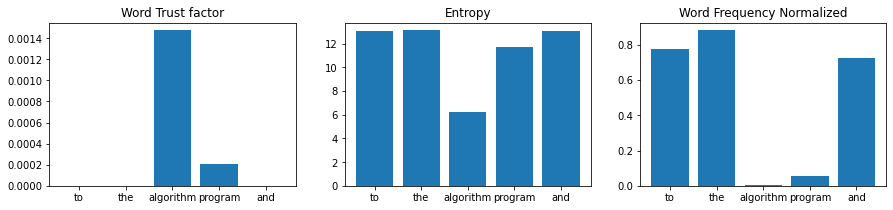

In [154]:
words = ["to", "the", "algorithm", "program", "and"]
# words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]

fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title(f"Word Trust factor")
ax1.bar(words, word_trust_factor[words])

ax2.set_title(f"Entropy")
ax2.bar(words, word_entropy[words])

ax3.set_title(f"Word Frequency Normalized")
ax3.bar(words, probability[words])

plt.show()

### Observe word_word_co ratios

In [155]:
wwc = (word_word_co * word_trust_factor)

=== Ploting software against ['to', 'the', 'algorithm', 'program', 'and'] ===


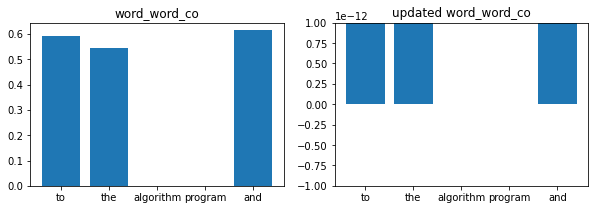

In [156]:
word = "software"

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

print(f"=== Ploting {word} against {words} ===")

ax1.set_title(f"word_word_co")
ax1.bar(words, word_word_co.loc[word][words])

ax2.set_title(f"updated word_word_co")
ax2.bar(words, wwc.loc[word][words])

plt.show()

In [157]:
wwc.loc["war"].sort_values(ascending=False).head(10)

racial         0.985954
ii             0.977344
prior          0.973940
possession     0.973940
supporter      0.972309
fighter        0.969148
ownership      0.967894
espionage      0.965894
revisionist    0.962728
sdpa           0.962692
Name: war, dtype: float64

In [149]:
word_word_co.loc["war"].sort_values(ascending=False).head(10)

zur                  0.985958
interestingly        0.985958
inhumane             0.985958
ingredient           0.985958
chancy               0.985958
sergey               0.985958
turbocharger         0.985958
ineffective          0.985958
indoors              0.985958
indistinguishable    0.985958
Name: war, dtype: float64

In [ ]:
word_word_co = wwc
del wwc

### Update word_word_co with word_word_co

In [361]:
word_frequency_norm = ((word_doc_freqency > 0).sum(0) / len(train_doc_vectors))
doc_word_distr = word_frequency_norm * (np.e**word_trust_factor)
doc_word_distr = (doc_word_distr.T / doc_word_distr.sum(1)).T.fillna(0)

In [362]:
doc_index = 13
word_doc_freqency.iloc[doc_index].sort_values(ascending=False).head(10)

directly     1.0
of           1.0
didn         1.0
10           1.0
maybe        1.0
his          1.0
missile      1.0
get          1.0
kill         1.0
operation    1.0
Name: 13, dtype: float64

In [363]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

desintegrated    0.038808
surgical         0.038461
directly         0.038448
missile          0.038448
operation        0.038447
body             0.038447
hit              0.038447
destroy          0.038447
someone          0.038447
house            0.038447
Name: 13, dtype: float64

In [357]:
print(labels[doc_index], train_docs[doc_index])

talk.politics.mideast maybe the missile didn t hit directly such that his body get desintegrated of course destroy 10 house to kill someone be not a surgical operation or be it


In [232]:
doc_word_distr.head()

,000,000th,0029,007,01,011,0119,013,02,0245,...,zillion,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [378]:
for di in range(len(doc_word_distr.index)):
    print(doc_word_distr.iloc[di].sort_values(ascending=False).head(5).index.to_list())
    break

['breed', 'domesticate', 'domestication', 'wild', 'exhibit']


In [379]:
(doc_word_distr.mean(0) * word_trust_factor).sort_values(ascending=False).head(10)

ironic             0.000545
humanist           0.000197
birthday           0.000181
45th               0.000181
drl                0.000023
nonononnononono    0.000010
nile               0.000010
incredibly         0.000008
huh                0.000008
photosynthetic     0.000007
dtype: float64

### Define Latent partitions

In [409]:
# reduction = None
reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 4
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    param_values = np.array([doc_word_distr.mean(1), doc_word_distr.std(1)]).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (400, 4)


In [410]:
distr_params.head()

,0,1,2,3
0,-0.004163,-0.007101,-0.006560,-0.014602
1,-0.003256,-0.005113,-0.003928,0.002366
2,-0.003288,-0.004822,-0.004353,-0.010058
3,-0.001184,0.001934,0.003075,0.003528
4,-0.002784,-0.003852,-0.002882,0.002375


### Using Kmeans MiniBatch

In [416]:
# num_of_topics = 4
# kmeans_model = MiniBatchKMeans(n_clusters=num_of_topics, random_state=0)

# num_of_iterations = 256

# num_of_samples = len(distr_params)
# batch_size = num_of_samples // 2

# for i in tqdm(range(num_of_iterations)):
#     indices = np.random.randint(num_of_samples, size=batch_size)
    
#     kmeans_model.partial_fit(distr_params.iloc[indices])

# kmeans_model.cluster_centers_.shape

(4, 4)

In [412]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)

In [417]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)

# wtf = normalize(dist, norm="l1", axis=1)
# wtf = normalize(wtf, norm="l1", axis=0)

wtf = gaussian(dist / dist.max(0))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (400, 4), predicted_labels has shape (400,)


In [418]:
wtf

array([[0.99928197, 0.81438448, 0.99993749, 0.80319777],
       [0.99980747, 0.81610347, 0.99989714, 0.81445361],
       [0.99954305, 0.81598989, 0.99999414, 0.80625491],
       ...,
       [0.9999297 , 0.81812275, 0.99983119, 0.81467086],
       [0.99923891, 0.8136871 , 0.99992277, 0.80278813],
       [0.99986256, 0.81784861, 0.99990108, 0.81408237]])

In [419]:
Counter(predicted_labels)

Counter({2: 225, 0: 172, 3: 1, 1: 2})

In [279]:
voc_array = np.array(vocabulary)

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])

def get_top2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].sum(0) * word_trust_factor).sort_values(ascending=False).head(10))
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))

In [280]:
get_top(0)

be      0.002779
the     0.002487
to      0.001867
of      0.001824
and     0.001515
you     0.001502
that    0.001450
have    0.001280
it      0.001274
in      0.001218
dtype: float64


In [281]:
get_top(1)

zur            0.0
enjoy          0.0
ensure         0.0
enrage         0.0
enough         0.0
enormous       0.0
ennumerated    0.0
enlighten      0.0
enhancement    0.0
entail         0.0
dtype: float64


In [282]:
get_top(2)

offender         5.450304e-11
cozy             5.450304e-11
theodore         5.450304e-11
kkkaldis         5.450304e-11
doublespeak      5.450304e-11
contradictory    5.432806e-11
disgust          5.431219e-11
harsh            5.430888e-11
justification    5.430882e-11
punishment       5.430876e-11
dtype: float64


In [283]:
get_top(3)

deletion       1.209994e-08
zur            0.000000e+00
enlighten      0.000000e+00
ensures        0.000000e+00
ensure         0.000000e+00
enrage         0.000000e+00
enough         0.000000e+00
enormous       0.000000e+00
ennumerated    0.000000e+00
enjoy          0.000000e+00
dtype: float64


### Evaluate Topic model with Train set

In [65]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 90.67%, 25 misclassified



### Evaluating Topic Model with test set

In [66]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 54.55%, avg-accuarcy = 72.61%, 60 misclassified



### Investigating Misclassification

In [89]:
training = True
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"==> predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")
#     break

              autos  religion  graphics     space
ve         0.000334  0.000191  0.001622  0.000000
sense      0.000426  0.001182  0.000000  0.000000
maybe      0.000000  0.000906  0.000605  0.000000
shot       0.000000  0.000677  0.000000  0.000371
that       0.000299  0.000251  0.000241  0.000251
kind       0.000000  0.000394  0.000588  0.000000
cheap      0.000000  0.000954  0.000000  0.000000
embarrass  0.000000  0.000954  0.000000  0.000000
fundies    0.000000  0.000954  0.000000  0.000000
josh       0.000000  0.000954  0.000000  0.000000
mood       0.000000  0.000954  0.000000  0.000000
mcdowell   0.000000  0.000954  0.000000  0.000000
be         0.000165  0.000224  0.000176  0.000203
of         0.000119  0.000248  0.000176  0.000181
to         0.000140  0.000208  0.000155  0.000176
okay       0.000000  0.000375  0.000293  0.000000
except     0.000307  0.000350  0.000000  0.000000
who        0.000148  0.000316  0.000030  0.000111
but        0.000055  0.000224  0.000197  0.000128


may       0.000021  0.000090  0.000056  0.000031
from phil g fraering pgf srl03 cacs usl edu right the profit caste be bless by god and may freely blare it presence in the even twilight
==> predicted_topic = religion, actual_topic = space 

            autos  religion  graphics     space
help     0.000000  0.000315  0.001873  0.000330
the      0.000425  0.000436  0.000395  0.000502
rest     0.000000  0.000886  0.000000  0.000424
shirt    0.000000  0.001130  0.000000  0.000000
night    0.000000  0.001130  0.000000  0.000000
delete   0.000000  0.001130  0.000000  0.000000
brown    0.000000  0.001130  0.000000  0.000000
of       0.000141  0.000293  0.000209  0.000215
out      0.000276  0.000259  0.000199  0.000120
in       0.000158  0.000150  0.000188  0.000167
can      0.000104  0.000085  0.000193  0.000155
about    0.000169  0.000113  0.000081  0.000073
anybody  0.000088  0.000057  0.000209  0.000041
find     0.000124  0.000046  0.000141  0.000030
rest delete can anybody out in a p h he

### Using Latent Dirichlet Allocation

In [68]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

train_accuracy = clf.score(train_doc_vectors, train_labels)
test_accuracy = clf.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

training_accuarcy = 100.00%, test_accuarcy = 62.88%, avg-accuarcy = 81.44%


### Next steps
use softwmax on word_trust factor, apply it on word_doc_norm like in word_word_co to suppress the stop words and make the actual important words more pronounced. use this pronounced words to estimate the related topic in doc